# Where There’s Smoke, There Might Be Fire
## Introduction

A smoke detector is an electronic device used to sense the presence of smoke, often sounding an alarm when it senses a certain level of particle concentration in a room's air. These sensors play a pivotal role in detecting fires early and giving people the necessary time to evacuate and call for help. However, smoke detectors have a high false alarm rate, which can create a false sense of security and potentially compromise fire safety. Our goal is to train a model that helps to improve smoke detector accuracy by using this dataset to answer the following predictive question: can we use a reading from a smoke detector to accurately predict whether or not there is an active fire?


The [dataset we'll be using](https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset) contains nearly 60,000 observations from a "smart" smoke detector, which records measurements from many different sensors. These include measurements related to particle concentration and type, air-related parameters, and environmental parameters, which were observed both with and without an active fire nearby. For this analysis, we will only focus on two of these variables: air temperature (degrees Celsius) and air humidity (percentage).

## Methods

In [1]:
library(tidyverse)
library(tidymodels)
set.seed(12345)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────────────────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.4     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.4     ✔ yardstick    1.1.0
✔ recipes      1.0.5     

── Co

First, we must download the dataset. Although we found it on Kaggle, it originates from an [article](https://www.hackster.io/stefanblattmann/real-time-smoke-detection-with-ai-based-sensor-fusion-1086e6) by Stefan Blattmann; we will read the .csv file from his [GitHub](https://github.com/Blatts01/ai-smokedetector).

After reading the data, we select the columns that we will use (temp, humidity, and fire), and rename them to be easier to work with. In a similar vein, we replace the numerical "fire" variable with a factor: "Fire" if a fire has been detected in an observation, and "No Fire" otherwise.

Finally, we take 25% of our data as a training set and put aside the remainder for testing.

In [2]:
smoke_data <- read_csv("https://raw.githubusercontent.com/Blatts01/ai-smokedetector/main/data/final.csv") |>
    rename_with(make.names) |> # Remove messy characters from column names
    select(Temperature.C., Humidity..., Fire.Alarm)

# Better column names
colnames(smoke_data) = c("temp", "humidity", "fire")   

smoke_data$fire[smoke_data$fire == 1] <- "Fire"
smoke_data$fire[smoke_data$fire == 0] <- "No Fire"
smoke_data <- mutate(smoke_data, fire = as_factor(fire))

# Split into training and testing data
smoke_split <- initial_split(smoke_data, prop = 0.25, strata = fire)
smoke_train <- training(smoke_split)
smoke_test <- testing(smoke_split)

Rows: 62630 Columns: 15
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (15): Temperature[C], Humidity[%], TVOC[ppb], eCO2[ppm], Raw H2, Raw Eth...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


To get a general idea of some of the properties of the data, we perform some preliminary data analysis.

Figure 1 illustrates the proportions of each class in the training data. There appears to be a bit under three times as many observations without fires compared to observations with fires. While this is not perfect, we believe that it is not unbalanced to the point where it will drastically harm our model.


We also calculate the mean, maximum, and minimum measurements of the two predictors, Temperature and Humidity (Figure 2).
This reveals significant differences in scale between the two quantities—when we build our KNN model, we will need to center and scale our predictors.

In [3]:
# Preliminary analysis

# Counts/proportions of each class:
smoke_counts <- smoke_train |>
    group_by(fire) |>
    summarise(count = n()) |>
    mutate(proportion = count/sum(count))
smoke_counts
print("Figure 1: Counts and proportions of each class")

# Means of measured quantities:
smoke_mean <- smoke_train |>
    select(-fire) |>
    map_df(mean)

smoke_max <- smoke_train |>
    select(-fire) |>
    map_df(max)

smoke_min <- smoke_train |>
    select(-fire) |>
    map_df(min)

smoke_summary <- cbind(smoke_mean, smoke_max, smoke_min) |> 
    pivot_longer(cols = everything(), names_to = "measurement")
smoke_summary["measurement"] = c("Mean Temp", "Mean Humidity", "Max Temp", "Max Humidity", "Min Temp", "Min Humidity")
smoke_summary
print("Figure 2: Mean, max, and min values of predictors")

fire,count,proportion
<fct>,<int>,<dbl>
No Fire,4468,0.2853676
Fire,11189,0.7146324


[1] "Figure 1: Counts and proportions of each class"


measurement,value
<chr>,<dbl>
Mean Temp,16.02895
Mean Humidity,48.60547
Max Temp,59.65000
Max Humidity,75.08000
Min Temp,-22.01000
Min Humidity,10.77000


[1] "Figure 2: Mean, max, and min values of predictors"


Plotting temperature against humidity (Figure 3), we observe some general trends. 

First, when both temperature and humidity are low, there are no fires. 
But when only one of the two quantities is high, fires are more common. 
However, when both temperature and humidity are moderately high, there is an area of overlap; it is unclear from the graph alone whether an observation in this region should have a fire or not. 

We will train a k-nearest-neighbors model to be able to quantitatively predict whether a reading represents an active fire.

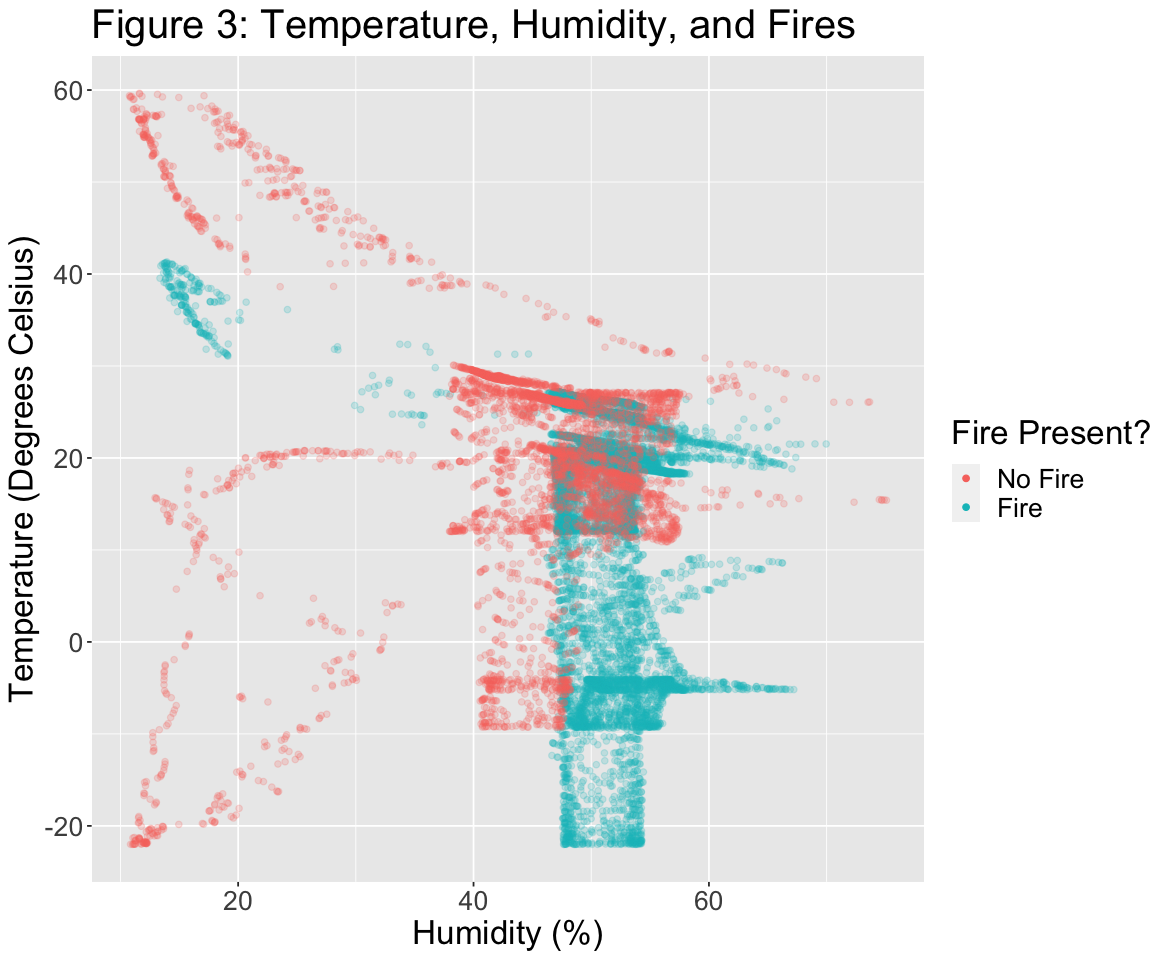

In [4]:
options(repr.plot.width = 9.75, repr.plot.height = 8)

smoke_plot <- smoke_train |>
    ggplot(aes(x = humidity, y = temp, color = fire)) +
    geom_point(alpha = 0.2) +
    ggtitle("Figure 3: Temperature, Humidity, and Fires") +
    labs(x = "Humidity (%)",
         y = "Temperature (Degrees Celsius)",
         color = "Fire Present?") +
    guides(color = guide_legend(override.aes = list(alpha = 1))) +
    theme(text = element_text(size = 20))
smoke_plot

We conduct five-fold cross-validation in order to determine the ideal number of neighbours for our model.

Since we have a large number of observations in our training set, we will perform two rounds of cross-validation: a rough first pass, with a few k values ranging from 1 to 501, and a finer pass on a smaller range of k that probably contains the best choice.

By looking at Figure 4, we can see that accuracy tends to decrease as k increases.

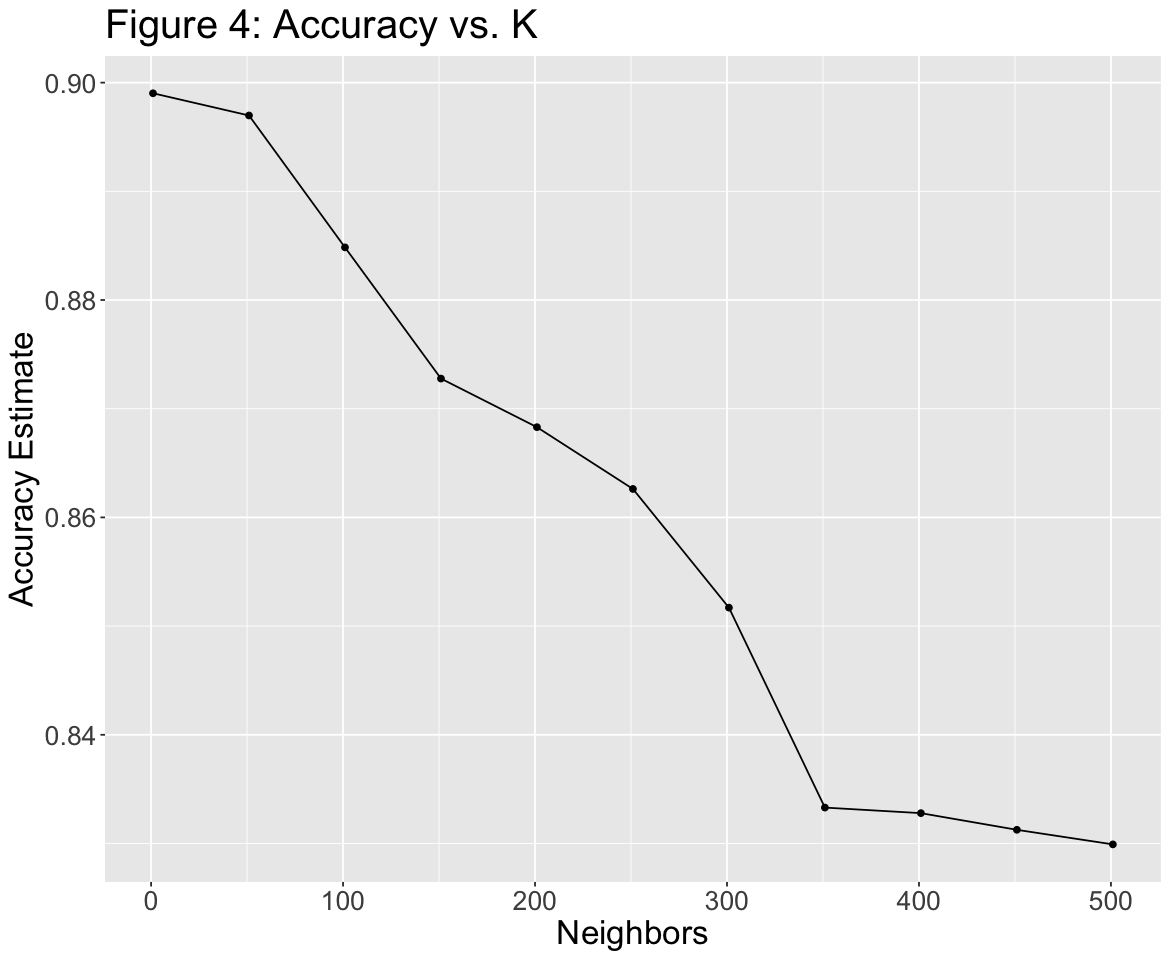

In [5]:
# knn model to determine best k
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

smoke_recipe <- recipe(fire ~ ., data = smoke_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

smoke_vfold <- vfold_cv(smoke_train, v = 5, strata = fire)

k_vals_1 = tibble(neighbors = seq(from = 1, to = 501, by = 50)) # rough first pass

smoke_results_1 <- workflow() |>
    add_model(knn_spec_tune) |>
    add_recipe(smoke_recipe) |>
    tune_grid(resamples = smoke_vfold, grid = k_vals_1) |>
    collect_metrics()

k_vs_acc_1 <- smoke_results_1 |>
  filter(.metric == "accuracy") |>
  ggplot(aes(x = neighbors, y = mean)) +
  ggtitle("Figure 4: Accuracy vs. K") +
  geom_line() +
  geom_point() +
  theme(text = element_text(size = 20)) +
  labs(x = "Neighbors", y = "Accuracy Estimate")
k_vs_acc_1

For our second round of cross-validation, we will test all k values between 1 and 60.

Figure 5 demonstrates that the ideal k is most likely 10, with an accuracy slightly above ~91%.

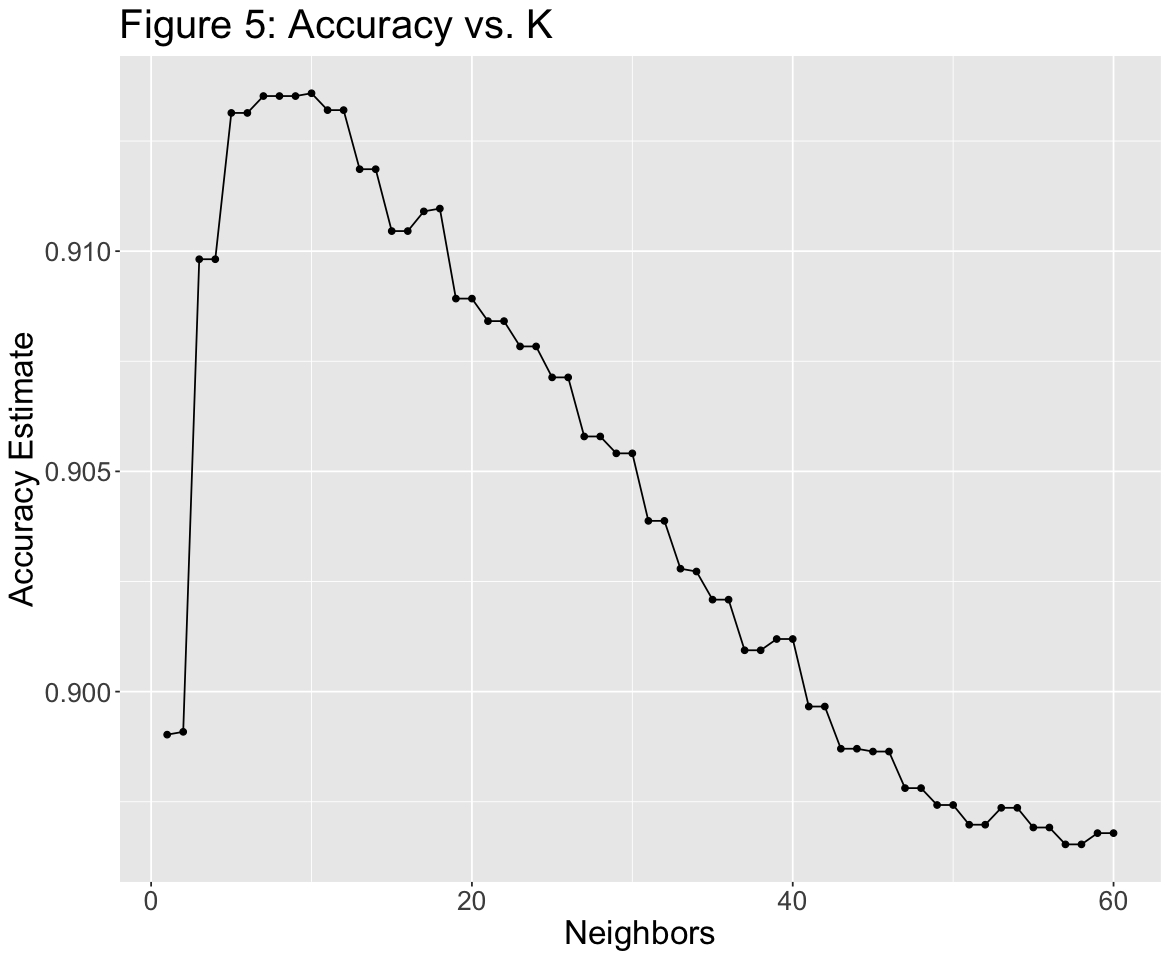

In [6]:
k_vals_2 = tibble(neighbors = 1:60) # fine-grained second pass

smoke_results_2 <- workflow() |>
  add_model(knn_spec_tune) |>
  add_recipe(smoke_recipe) |>
  tune_grid(resamples = smoke_vfold, grid = k_vals_2) |>
  collect_metrics()

k_vs_acc_2 <- smoke_results_2 |>
  filter(.metric == "accuracy") |>
  ggplot(aes(x = neighbors, y = mean)) +
  ggtitle("Figure 5: Accuracy vs. K") +
  geom_line() +
  geom_point() +
  theme(text = element_text(size = 20)) +
  labs(x = "Neighbors", y = "Accuracy Estimate")
k_vs_acc_2

We sort by accuracy, select the best k, and use it to create a new model specification.

In [11]:
best_k <- smoke_results_2 |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(neighbors)

knn_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")       

## Results

Now that we have found the ideal number of neighbors, we can fit our model to the training set and use it to predict values from the testing set.

The final accuracy of the model is **91.57%**.

By observing the confusion matrix (Figure 6), we can see that the model tends to mistakenly predict "Fire" (false positive) about twice as often as it mistakenly predicts "No Fire" (false negative). 
For a fire alarm, this is arguably better than the inverse situation!

In [8]:
smoke_fit <- workflow() |>
  add_recipe(smoke_recipe) |>
  add_model(knn_spec_best) |>
  fit(data = smoke_train)

smoke_predicted <- smoke_fit |>
  predict(smoke_test) |>
  bind_cols(smoke_test)

smoke_accuracy <- smoke_predicted |>
  metrics(truth = fire, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  pull(.estimate)
smoke_accuracy

conf_mat <- smoke_predicted |>
    conf_mat(truth = fire, estimate = .pred_class)
conf_mat
print("Figure 6: Confusion matrix for the model.")


[1] 0.9157175

          Truth
Prediction No Fire  Fire
   No Fire   10667  1221
   Fire       2738 32347

[1] "Figure 6: Confusion matrix for the model."


Finally, we can visualize the outputs of our model for a range of inputs by creating a decision boundary plot (Figure 7). 

This plot reinforces what we hypothesized in our preliminary analysis: when both humidity and temperature are either low or high, the chance of a fire is low. But when just one of the two variables is very high, or both variables are moderately high, there is likely an active fire.

In [9]:
# create the grid of temperature/humidity vals, and arrange in a data frame
temp_grid <- seq(min(smoke_data$temp), 
                max(smoke_data$temp), 
                length.out = 100)
humid_grid <- seq(min(smoke_data$humidity), 
                max(smoke_data$humidity), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(temp = temp_grid, 
                                humidity = humid_grid))

# bind the predictions as a new column with the grid points
prediction_table <- predict(smoke_fit, asgrid) |> 
    bind_cols(asgrid)

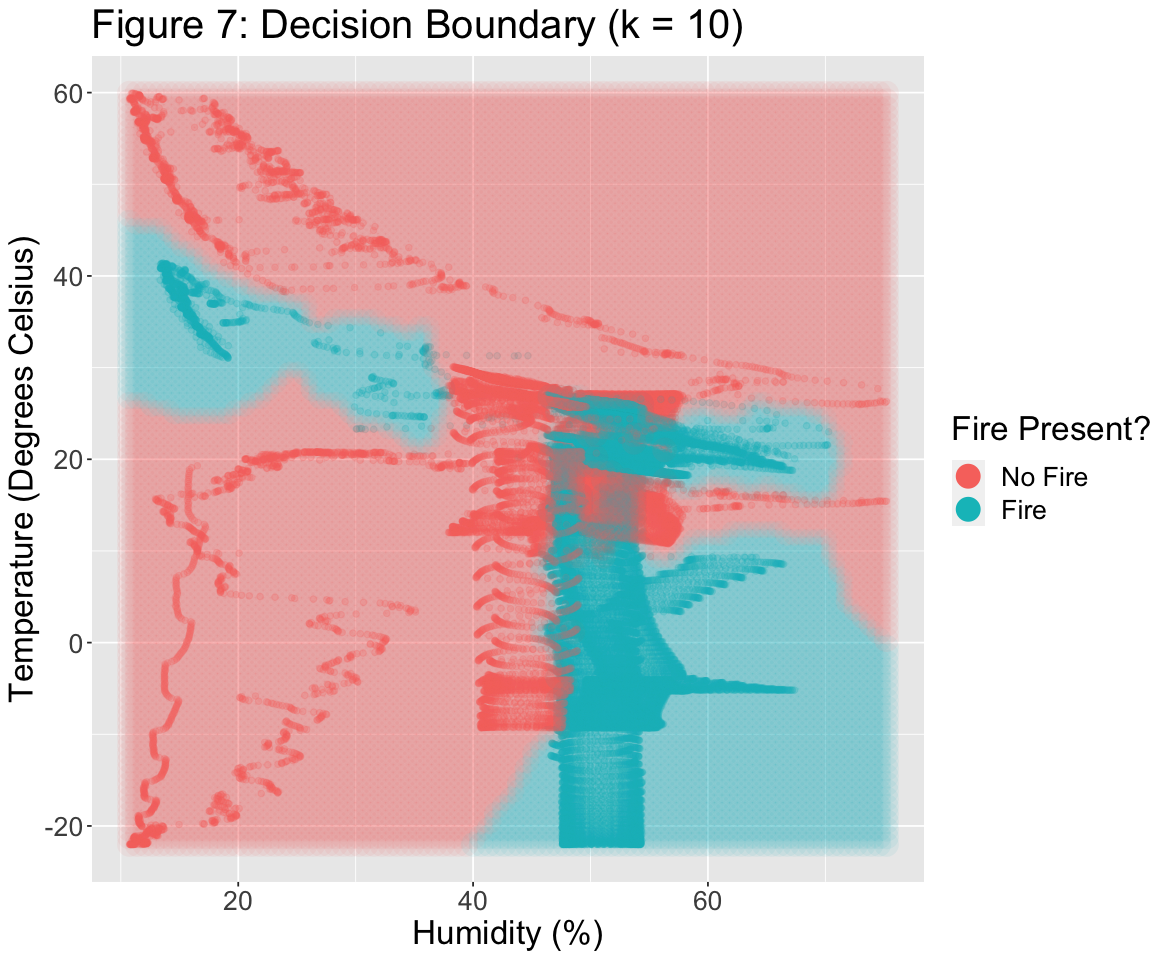

In [10]:
boundary_plot <- ggplot() +
    geom_point(data = smoke_data, aes(x = humidity, y = temp, color = fire), alpha = 0.2) +
    geom_point(data = prediction_table, aes(x = humidity, y = temp, color = .pred_class),
                alpha = 0.075, 
                size = 7,
                stroke = NA) +
    ggtitle(paste("Figure 7: Decision Boundary (k = ", best_k, ")", sep = "")) +
    labs(x = "Humidity (%)", y = "Temperature (Degrees Celsius)", color = "Fire Present?") +
    guides(color = guide_legend(override.aes = list(alpha = 1))) +
    theme(text = element_text(size = 20))
boundary_plot

## Discussion

## References


Blattmann, S. (2022, August 3). Real-time smoke detection with AI-based sensor fusion. Hackster.io. Retrieved April 3, 2023, from 
https://www.hackster.io/stefanblattmann/real-time-smoke-detection-with-ai-based-sensor-fusion-1086e6#code 

Bordbar, H., Alinejad, F., Conley, K., Ala-Nissila, T., &amp; Hostikka, S. (2022). Flame detection by heat from the infrared spectrum: Optimization and Sensitivity Analysis. Fire Safety Journal, 133, 103673. https://doi.org/10.1016/j.firesaf.2022.103673 

Log, T. (2017). Indoor relative humidity as a fire risk indicator. Building and Environment, 111, 238–248. https://doi.org/10.1016/j.buildenv.2016.11.002 

# TODO DELETE ALL CELLS BELOW WHEN DONE REPORT

## Methods

We will attempt to use the K-nearest neighbors algorithm to predict whether or not a smoke detector reading represents an active fire, according to these steps:

1. Data Collection: Read data from remote GitHub repository containing the raw .csv file.

2. Data Preprocessing: Select relevant columns, and rename them to be more descriptive. Replace numerically-represented categorical variables with factors. Normalize and center the data, then split the preprocessed data into a training and testing set. 

3. Model Training: Train a KNN model on the training set by assigning a class label (fire or non-fire) to each data point based on its neighbors. We will use humidity and temperature for our analysis.

4. Model Evaluation: Use 5-fold cross validation to determine the value of K which maximizes precision. Estimate the accuracy of our model using the testing set we created earlier.

5. Visualizations and Conclusions: Create visualizations (decision boundary plots, scatter plots) and draw a conclusive answer to our predictive question: Can we predict whether there is an active fire based on a smoke alarm reading? Furthermore, how confident can we be in our predictions?

## Expected Outcomes and Significance

We expect to find that smoke alarm readings are a relatively accurate predictor of fires.

The variables we are analyzing are both closely related to fires: fires cause high temperatures, and combustion reactions produce H2O as water vapour, which may increase humidity. On the other hand, the heat produced by fires dries out the air, which could reduce humidity. Either way, there is reason to believe that humidity and fire are linked.

Our visualizations indicate that there are regions of values which contain exclusively fire/no fire readings, but other regions where both classes overlap. This may harm our model's accuracy.

These findings could help inform the designs of future smoke/fire detectors, and improve their accuracy.
Instead of detecting fire using only one variable, a future smoke detector could consider multiple variables and pass their values through our prediction model (if it is sufficiently accurate).

Some future questions include:
- Are there other, more relevant variables that should be considered in this analysis?
- Are there different prediction models that would yield greater results?
- Are there any biases in this data that skew our outcomes?